In [ ]:
# conda env list

# conda create  -n [이름] python=[버전]
# conda activate [이름]

# conda deactivate
# conda remove -n [이름] --all

In [ ]:
# 입력-> 토큰화 및 시퀀스 변화 -> 패딩(고정길이화) -> 임베딩(단어->벡터화)-> 1D Convolution + poling 반복
# -> Flatten ->Dense(은닉) -> 출력(소프트맥스, 이진분류) -> 학습(Adam + binary_Crossentropy)
# -> 검증/테스트 평가 -> 시각화

- 말뭉치 로딩(nltk)  데이터 로딩
- 토큰화(빈고 기반 인덱싱) 텍스트를 숫자로 변환
- 시퀀스 패딩   고정길이 배치 구성
- 임베딩  단어를 dense vector표현 학습
- 임베딩  발전
    - 한계 : 작은데이터에서는 일반화 부족
    - 발전 : 사전학습(Word2vec), 문맥적 임베딩(BERT, GPT)

In [11]:
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# sample data
texts = [
    'I really love this movie',
    'I hate this boring film',
    'love love great film'
]
# 토큰화 객체(최대 단어 10, oov 토큰 지정)
tokenizer = Tokenizer(num_words=10, oov_token='UNK')
tokenizer.fit_on_texts(texts)
print(f'단어인덱스 : {tokenizer.word_index}')
# 시퀀스
seqs = tokenizer.texts_to_sequences(texts)
print(f'원본 시퀀스 : {seqs}')
# 패딩(최대 길이를 6)
padded = pad_sequences(seqs, maxlen=6,padding='post')
print(f'패딩결과 : {padded}  사이즈 : {padded.shape}')


단어인덱스 : {'UNK': 1, 'love': 2, 'i': 3, 'this': 4, 'film': 5, 'really': 6, 'movie': 7, 'hate': 8, 'boring': 9, 'great': 10}
원본 시퀀스 : [[3, 6, 2, 4, 7], [3, 8, 4, 9, 5], [2, 2, 1, 5]]
패딩결과 : [[3 6 2 4 7 0]
 [3 8 4 9 5 0]
 [2 2 1 5 0 0]]  사이즈 : (3, 6)


In [13]:
# 임베딩 : 임베딩 레이어
import tensorflow as tf
# 패딩된 시퀀스  padded
vocab_size = 11  # unk 포함 단어인덱스 최대값 + 1
embed_dim = 4  # 작은 차원
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embed_dim, input_length=6)    
])
embeddings = model.predict(padded)
print(f'임베딩 텐서 모양 : {embeddings.shape}')  #(3,6,4)
print(f'첫 문장 첫 단어 벡터 : {embeddings[0,0,:]}')

c:\Users\playdata2\miniconda3\envs\LLM311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
임베딩 텐서 모양 : (3, 6, 4)
첫 문장 첫 단어 벡터 : [ 0.04000187 -0.02458723  0.01764833  0.0096667 ]


In [17]:
# 1D Convolution
import numpy as np
import tensorflow as tf
# 임의 시퀀스(배치=1, 길이=6, 임베딩=4)
x = np.random.randn(1,6,4).astype('float32')
conv = tf.keras.layers.Conv1D(
    filters = 2  # 2개의 패턴을 감지  긍정 부정을 감지
    ,kernel_size=3  # 3-gram
    ,activation='relu'  
)
y = conv(x)
print(f'입력 shape {x.shape}')
print(f'출력 shape {y.shape}')
print(f'출력값  {y.numpy()}')

입력 shape (1, 6, 4)
출력 shape (1, 4, 2)
출력값  [[[0.21842088 1.464069  ]
  [0.         0.08337156]
  [0.         0.        ]
  [2.0848384  1.3942744 ]]]


In [18]:
# MaxPooling
pool = tf.keras.layers.MaxPooling1D(pool_size=2)
pooled = pool(y)
print(f'before pooling :{y.shape}')
print(f'after pooling :{pooled.shape}')

before pooling :(1, 4, 2)
after pooling :(1, 2, 2)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  # 단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  #길이 맞추기
texts = [
    'I really love this movie',  # 긍정
    'I hate this boring film',  # 부정
    'great love movie',  # 긍정
    'boring hate film' # 부정
]
labels = np.array([0,1,0,1])

tokenizer = Tokenizer(num_words=50,oov_token='UNK')
tokenizer.fit_on_texts(texts)  # 단어사전 생성
seqs =  tokenizer.texts_to_sequences(texts)  # 단어사전기반으로 단어들을 숫자로 변경(길이는 다름)
x = pad_sequences(seqs,maxlen=6,padding='post')
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(50,8,input_length=6),
    tf.keras.layers.Conv1D(16,3,activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
history =model.fit(x,labels,epochs=15)

Epoch 1/15


c:\Users\playdata2\miniconda3\envs\LLM311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - acc: 0.2500 - loss: 0.6937
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.7500 - loss: 0.6924
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.7500 - loss: 0.6917
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - acc: 1.0000 - loss: 0.6907
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 1.0000 - loss: 0.6897
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - acc: 1.0000 - loss: 0.6888
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - acc: 1.0000 - loss: 0.6879
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 1.0000 - loss: 0.6870
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - acc: 1.0000 - loss: 0.6860
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - acc: 1.0000 - loss: 0.6850
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - acc: 1.0000 - loss: 0.6839
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - acc: 1.0000 - loss: 0.6829
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - acc: 1.0000 - loss: 0.

In [26]:
print(f"최종훈련 정확도 : {history.history['acc'][-1]}")
preds = model.predict(x)
print(preds.reshape(-1))
print(f'라벨 : {labels}')

최종훈련 정확도 : 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[0.4849767  0.5071421  0.49971595 0.5074049 ]
라벨 : [0 1 0 1]


In [27]:
# nltk 데이터로드
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\playdata2\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [28]:
# 재현성 시드 고정
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [31]:
# 데이터로딩
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [ movie_reviews.categories(id)[0] for id in ids]

In [ ]:
# 하이퍼파라메터
max_words = 10000 # 최대단어수
maxlen = 500 # 문서길이
embed_dim = 64 # 임베딩차원
batch_size = 256 # batch_size
epochs = 15 # epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words,oov_token='UNK')
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x,maxlen=maxlen,truncating='post')

# 라벨인코딩
label_map = {'pos':0,'neg':1}
y = np.array([label_map.get(c) for c in categories])
# train/test 분할
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, random_state=42, test_size=0.2)
# 모델구성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words+1,output_dim=embed_dim,input_length=maxlen),
    tf.keras.layers.Conv1D(128,3,activation='relu'),
    tf.keras.layers.MaxPool1D(),  # 시퀀스의 구간별 특징 요약
    tf.keras.layers.Conv1D(256,3,activation='relu'),
    # tf.keras.layers.GlobalAvgPool1D()  # 전체시퀀스의 평균  시퀀스차원없애고 채널 축만남김(채널에대한평균)
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

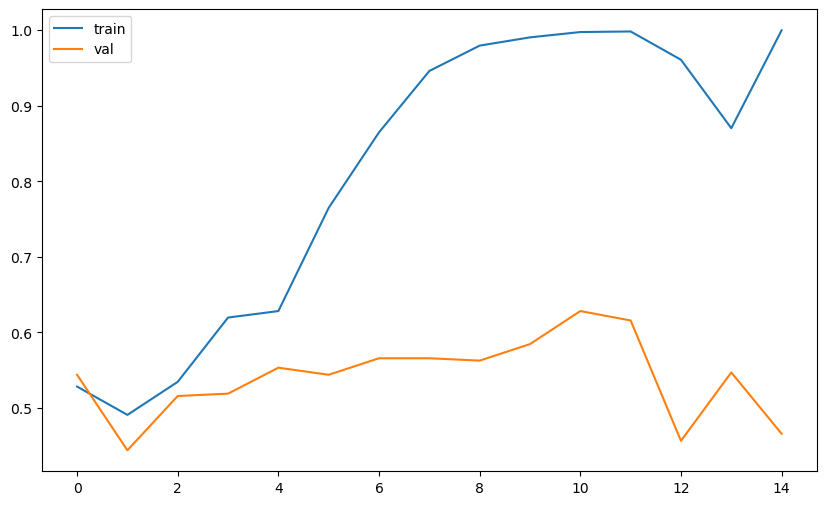

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.5250 - loss: 1.0162
test loss : 1.0162343978881836  test acc : 0.5249999761581421


In [ ]:
# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

In [50]:
# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


array([[0.48418844],
       [0.48370814]], dtype=float32)

In [ ]:
#conv1d   배치크기, 시퀀스길이, 채널수
x = tf.random.normal((32,10,64))
print(tf.keras.layers.Flatten()(x).shape)  
tf.keras.layers.GlobalAvgPool1D()(x).shape  # 각 채널 Feature map 마다 평균

(32, 640)


TensorShape([32, 64])